In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
shared_path = '/content/drive/MyDrive/Global_Code_Bridge'

Mounted at /content/drive


In [ ]:
# Install required packages
import random
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
import shutil

In [3]:
# Enable GPU for faster training
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
df = pd.read_table(shared_path+"/cat_emails_v2.csv", sep=',')

In [5]:
# Split data
train_df, test_df = train_test_split(df, test_size=500, random_state=42, stratify=df['category'])
print(f"Training: {len(train_df)}, Test: {len(test_df)}")

Training: 4500, Test: 500


**GBERT**

In [ ]:
def train_german_gbert_model(train_df, test_df):
    
    # Choose the best German model
    model_name = "deepset/gbert-large"

    # 1. Prepare the datasets
    print(" Preparing datasets...")

    # Get unique categories and create mappings
    unique_categories = sorted(train_df['category'].unique())
    category_to_id = {cat: i for i, cat in enumerate(unique_categories)}
    id_to_category = {i: cat for cat, i in category_to_id.items()}

    # Apply my winning preprocessing (subject emphasized)
    def weighted_combine(subject, email):
        return f"{subject} {subject} {email}"

    # Use raw text without any cleaning
    train_df['weighted_text'] = train_df.apply(
        lambda x: weighted_combine(x['subject'], x['email']), axis=1
    )
    test_df['weighted_text'] = test_df.apply(
        lambda x: weighted_combine(x['subject'], x['email']), axis=1
    )

    # Convert labels to numerical
    train_df['label'] = train_df['category'].map(category_to_id)
    test_df['label'] = test_df['category'].map(category_to_id)

    # 2. Load tokenizer and tokenize
    print(" Tokenizing datasets...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_function(examples):
        return tokenizer(
            examples['weighted_text'],
            padding=True,
            truncation=True,
            max_length=768, # last best result was with 768
            return_tensors="pt"
        )

    # Convert to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train_df[['weighted_text', 'label']])
    test_dataset = Dataset.from_pandas(test_df[['weighted_text', 'label']])

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    # 3. Load model
    print(" Loading GBERT-Large model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(unique_categories)
    )

    # 4. Training arguments
    training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Global_Code_Bridge/champion_gbert",
    num_train_epochs=6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    save_strategy="epoch",
    eval_strategy="epoch", 
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    fp16=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=2,
    gradient_accumulation_steps=2,
    dataloader_pin_memory=False,
)

    # 5. Metrics
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        return {
            "accuracy": accuracy_score(labels, predictions),
            "f1_macro": f1_score(labels, predictions, average='macro'),
            "f1_weighted": f1_score(labels, predictions, average='weighted')
        }

      # 6. Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,  
        tokenizer=tokenizer,
    )

      # 7. Train the model
    print(" Starting GBERT-Large training...")
    print(f" Training samples: {len(tokenized_train)}")
    print(f" Test samples: {len(tokenized_test)}")
    print(f" Number of categories: {len(unique_categories)}")
    print(f" Enhanced features: {training_args.num_train_epochs} epochs, cosine LR, F1 metrics")

    trainer.train()

    # Get predictions for detailed analysis
    predictions = trainer.predict(tokenized_test)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = tokenized_test['label']

    # Calculate all metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f" Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f" F1 Macro:    {f1_macro:.4f} ({f1_macro*100:.2f}%)")
    print(f" F1 Weighted: {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")

    # Show worst-performing categories
    report = classification_report(y_true, y_pred, target_names=list(id_to_category.values()), output_dict=True)

    f1_scores = {}
    for category, metrics in report.items():
        if category not in ['accuracy', 'macro avg', 'weighted avg']:
            f1_scores[category] = metrics['f1-score']

    worst_categories = sorted(f1_scores.items(), key=lambda x: x[1])[:5]

    print(f"\n Top 5 worst categories by F1:")
    for category, f1 in worst_categories:
        print(f"   {category}: {f1:.3f}")

    return trainer, tokenizer, accuracy, f1_macro, f1_weighted, id_to_category, worst_categories

trainer, tokenizer, accuracy, f1_macro, f1_weighted, id_to_category, worst_categories = train_german_gbert_model(train_df, test_df)

 Preparing datasets...
 Tokenizing datasets...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

 Loading GBERT-Large model...


model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1079527560.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 Starting GBERT-Large training...
 Training samples: 4500
 Test samples: 500
 Number of categories: 34
 Enhanced features: 6 epochs, cosine LR, F1 metrics


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.285200,1.016891,0.714000,0.693825,0.709108
2,0.552200,0.429931,0.858000,0.857437,0.855519
3,0.372400,0.437670,0.848000,0.842224,0.845905
4,0.221100,0.300148,0.886000,0.887442,0.886986
5,0.198700,0.284187,0.900000,0.901281,0.899894
6,0.139400,0.285976,0.900000,0.903341,0.900295


 Accuracy:    0.9000 (90.00%)
 F1 Macro:    0.9033 (90.33%)
 F1 Weighted: 0.9003 (90.03%)

 Top 5 worst categories by F1:
   Bank statement: 0.714
   Financing balance residual value leasing: 0.769
   Credit item: 0.815
   Financing balance credit: 0.815
   Insurance offer: 0.837


In [7]:
def save_enhanced_model_with_metrics(trainer, tokenizer, id_to_category, accuracy, f1_macro, f1_weighted, worst_categories):
    """Save model with performance metrics"""

    trainer.save_model("./champion_gbert")
    tokenizer.save_pretrained("./champion_gbert")

    with open('category_mappings_gbert.pkl', 'wb') as f:
        pickle.dump({
            'id_to_category': id_to_category,
            'category_to_id': {v: k for k, v in id_to_category.items()},
            'performance_metrics': {
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted
            },
            'worst_categories': worst_categories
        }, f)

    print(f" Model saved!")
    print(f" Performance: Accuracy={accuracy:.4f}, F1 Macro={f1_macro:.4f}")

# Save after training
save_enhanced_model_with_metrics(trainer, tokenizer, id_to_category, accuracy, f1_macro, f1_weighted, worst_categories)

 Model saved!
 Performance: Accuracy=0.9000, F1 Macro=0.9033


**Deployment**

In [ ]:
# Saving the model
trainer.save_model("champion_gbert")
tokenizer.save_pretrained("champion_gbert")

# Also save category mappings
with open('category_mappings_gbert.pkl', 'wb') as f:
    pickle.dump({
        'id_to_category': id_to_category,
        'category_to_id': {v: k for k, v in id_to_category.items()}  # Create reverse mapping
    }, f)


# Create zip file of the model
shutil.make_archive('champion_gbert', 'zip', 'champion_gbert')
files.download('champion_gbert.zip')
files.download('category_mappings_gbert.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

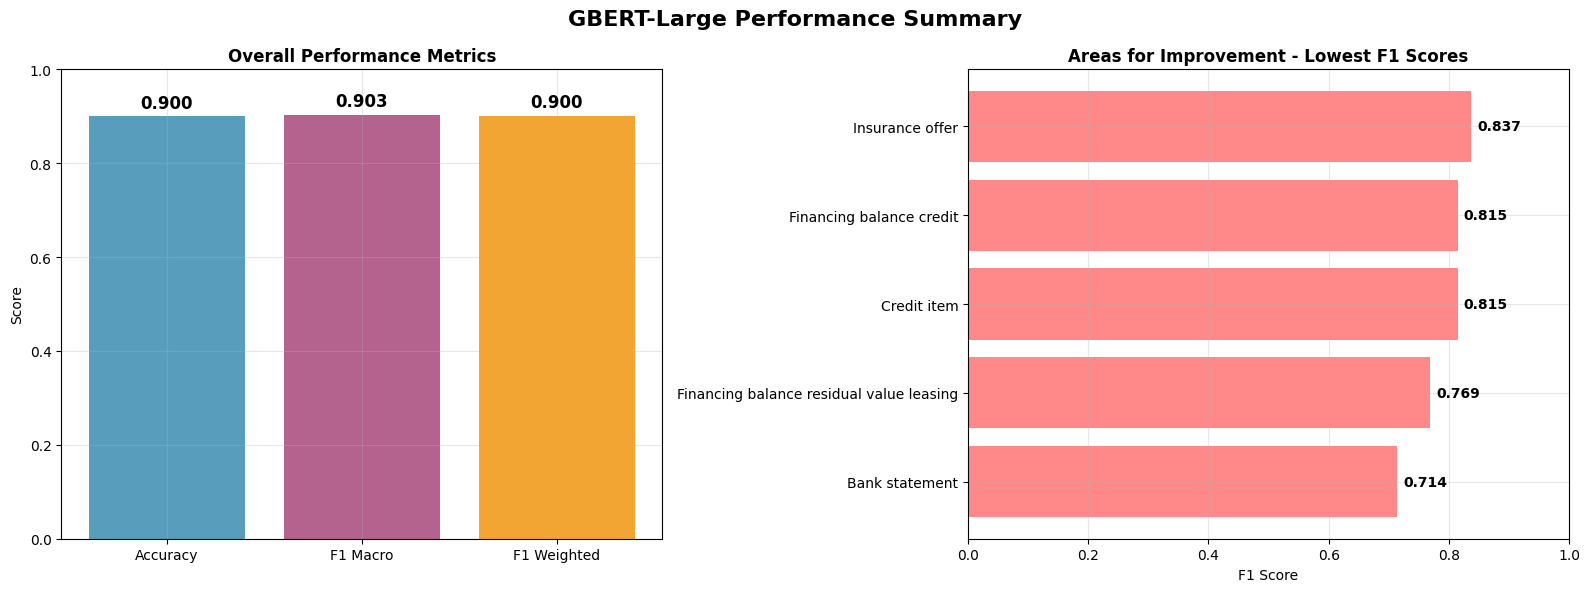

GBERT-LARGE - ASSESSMENT PERFORMANCE REPORT
Accuracy:    0.9000 (90.00%)
F1 Macro:    0.9033 (90.33%)
F1 Weighted: 0.9003 (90.03%)
Number of Categories: 34

MODEL STRENGTHS:
✓ High overall accuracy (90.0%)
✓ Balanced performance (F1 Macro: 90.3%)
✓ Handles 34 different email categories

AREAS FOR IMPROVEMENT:
1. Bank statement: F1 = 0.714
2. Financing balance residual value leasing: F1 = 0.769
3. Credit item: F1 = 0.815
4. Financing balance credit: F1 = 0.815
5. Insurance offer: F1 = 0.837


In [ ]:
def visualize_existing_results(accuracy, f1_macro, f1_weighted, worst_categories, id_to_category, model_name="GBERT-Large"):
    """
    Create visualizations using the metrics, computed during training
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{model_name} Performance Summary', fontsize=16, fontweight='bold')

    # 1. Main Metrics
    metrics = ['Accuracy', 'F1 Macro', 'F1 Weighted']
    values = [accuracy, f1_macro, f1_weighted]
    colors = ['#2E86AB', '#A23B72', '#F18F01']

    bars = axes[0].bar(metrics, values, color=colors, alpha=0.8)
    axes[0].set_title('Overall Performance Metrics', fontweight='bold')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # 2. Worst Performing Categories
    categories = [cat for cat, score in worst_categories]
    scores = [score for cat, score in worst_categories]

    bars = axes[1].barh(range(len(categories)), scores, color='#FF6B6B', alpha=0.8)
    axes[1].set_yticks(range(len(categories)))
    axes[1].set_yticklabels(categories)
    axes[1].set_title('Areas for Improvement - Lowest F1 Scores', fontweight='bold')
    axes[1].set_xlabel('F1 Score')
    axes[1].set_xlim(0, 1)
    axes[1].grid(True, alpha=0.3)

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, scores)):
        axes[1].text(value + 0.01, bar.get_y() + bar.get_height()/2.,
                    f'{value:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed summary
    print("="*70)
    print(f"{model_name.upper()} - ASSESSMENT PERFORMANCE REPORT")
    print("="*70)
    print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1 Macro:    {f1_macro:.4f} ({f1_macro*100:.2f}%)")
    print(f"F1 Weighted: {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
    print(f"Number of Categories: {len(id_to_category)}")
    print("="*70)

    print(f"\nMODEL STRENGTHS:")
    print(f"✓ High overall accuracy ({accuracy*100:.1f}%)")
    print(f"✓ Balanced performance (F1 Macro: {f1_macro*100:.1f}%)")
    print(f"✓ Handles {len(id_to_category)} different email categories")

    print(f"\nAREAS FOR IMPROVEMENT:")
    for i, (category, score) in enumerate(worst_categories, 1):
        print(f"{i}. {category}: F1 = {score:.3f}")


visualize_existing_results(accuracy, f1_macro, f1_weighted, worst_categories, id_to_category)

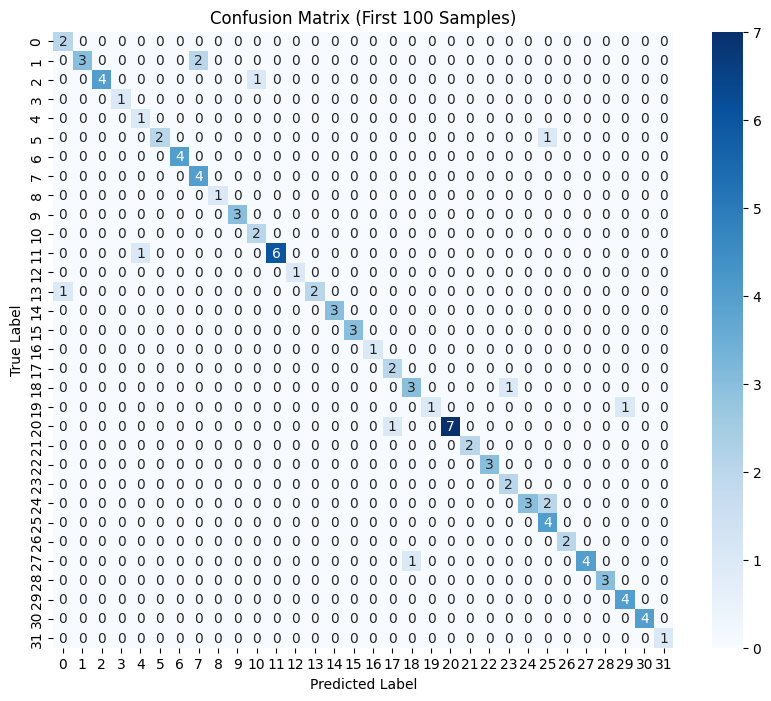

Sample Accuracy: 88.0%


In [ ]:
def confusion_matrix(trainer, test_df, tokenizer, id_to_category, max_samples=100):
    """Create a confusion matrix"""

    # Use only a subset to save GPU
    # Explicitly create a copy to avoid SettingWithCopyWarning
    sample_df = test_df.head(max_samples).copy()

    # Apply my winning preprocessing (subject emphasized)
    def weighted_combine(subject, email):
        return f"{subject} {subject} {email}"

    sample_df['weighted_text'] = sample_df.apply(
        lambda x: weighted_combine(x['subject'], x['email']), axis=1
    )

    # Tokenize just the samples
    inputs = tokenizer(sample_df['weighted_text'].tolist(),
                      padding=True, truncation=True,
                      max_length=512, return_tensors="pt")

    # Predict
    with torch.no_grad():
        # Move inputs to the same device as the model
        inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}
        outputs = trainer.model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

    # Create mini confusion matrix
    # Map original categories to numerical labels for the sample_df
    unique_categories = sorted(test_df['category'].unique())
    category_to_id = {cat: i for i, cat in enumerate(unique_categories)}
    sample_df['label'] = sample_df['category'].map(category_to_id) 

    y_true = sample_df['label'].values
    y_pred = predictions.cpu().numpy() # Move predictions back to CPU for sklearn

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (First {max_samples} Samples)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    sample_accuracy = (y_true == y_pred).mean()
    print(f"Sample Accuracy: {sample_accuracy:.1%}")

confusion_matrix(trainer, test_df, tokenizer, id_to_category)